# Advanced Lane Lines

This notebook will serve as both the writeup and executable notebook for this project.

## Imports and Variables

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from moviepy.editor import VideoFileClip # needed to edit/save/watch video clips
from IPython.display import HTML

nx = 9               # the number of inside corners in x of provided chessboard
ny = 6               # the number of inside corners in y

debug = False        # set to True to enhance diagnostic messages
first_frame = True   # used to improve efficiency of sliding window searches

ym_per_pix = 30/720  # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Camera Calibration

I began with the starter code provided in the course materials at https://github.com/udacity/CarND-Camera-Calibration. 

I start by preparing object points in an array *objp*, which contains the (x, y, z) coordinates of the chessboard corners in world space. This assumes the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image. Thus, *objp* is just a replicated array of coordinates, and objp will be appended with a copy of new coordinates every time I successfully detect all chessboard corners in a test image. Another array, imgpoints, will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.

I then use objpoints and imgpoints to compute the camera calibration and distortion coefficients using cv2.calibrateCamera(). I applied this distortion correction to the test image using cv2.undistort(). The code and a sample result appear in the next two cells.

## Utility Methods

In [2]:
## utility methods 

def calibrate():
    objp = np.zeros((ny*nx,3), np.float32) # prepare object points, like (0,0,0), (1,0,0) ...
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    images = glob.glob('camera_cal/calibration*.jpg') # glob a list from calibration images

    for idx, fname in enumerate(images):
        gray = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None) # Find chessboard corners

        if ret == True: # # If success, add points
            objpoints.append(objp)
            imgpoints.append(corners)
            
    _, mtx, dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    
    return mtx, dist

def corners_unwarp(img, nx, ny, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    gray = cv2.cvtColor(undist,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if ret == True: # corners were found
            cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
            src = np.float32([corners[0], corners[nx-1],
                corners[len(corners[:])-nx], corners[len(corners[:])-1]])
            offset = 100; # specify an offset to map the unwarped into
            dst = np.float32([[offset,offset], [gray.shape[1]-offset,offset],
                [offset,gray.shape[0]-offset], [gray.shape[1]-offset,gray.shape[0]-offset]])
            Minv = cv2.getPerspectiveTransform(dst, src)
            M = cv2.getPerspectiveTransform(src, dst)
            warped = cv2.warpPerspective(undist, M, (img.shape[1], img.shape[0]), 
                flags=cv2.INTER_LINEAR)
    return warped, M, Minv

def carnd_camera(): # parameters for carnd videos, settings for region_of_interest
    w, h, h_clip_factor = 1280, 720, 0.50
    vertices = np.array([[(w*.04, h), (w*.45, h*h_clip_factor), (w*.54, h*h_clip_factor), (w*.96, h)]], dtype=np.int32)
    return vertices, h_clip_factor

## Validate calibration and unwarping 

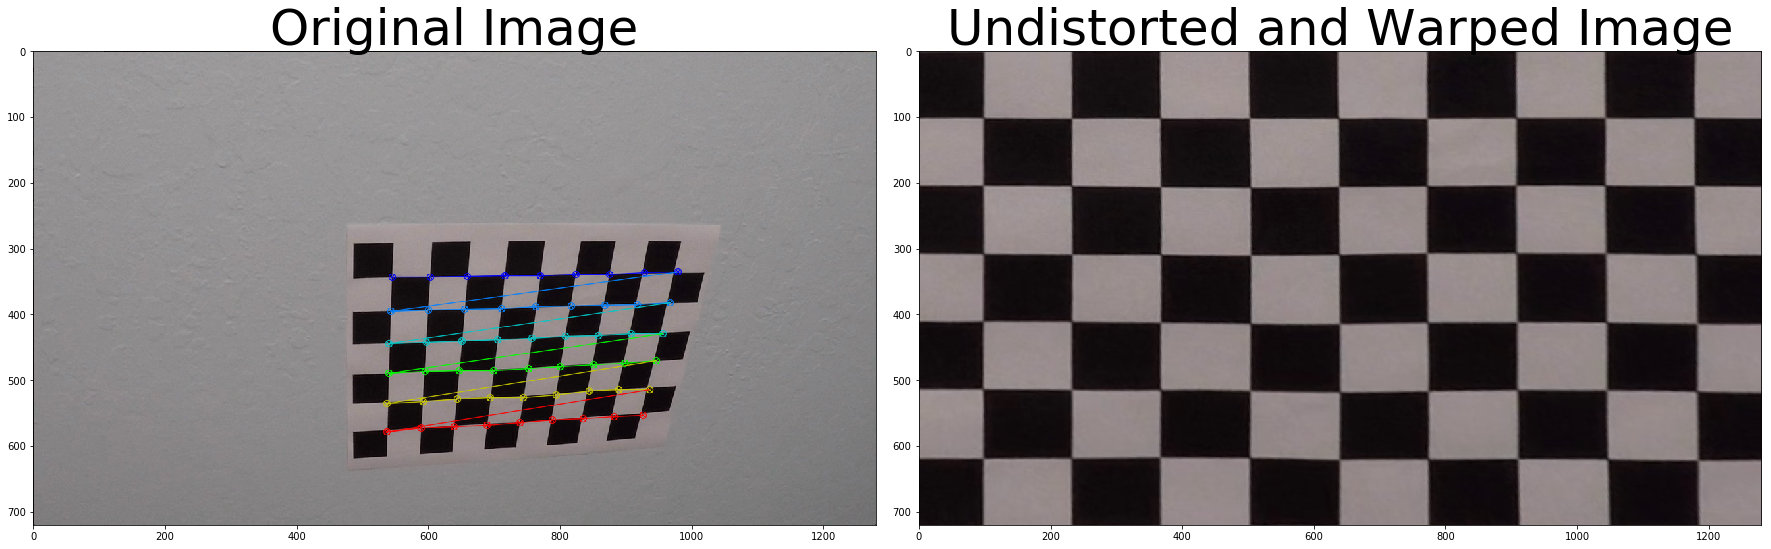

In [3]:
mtx, dist = calibrate()

# Read in an image
img = cv2.imread('camera_cal/calibration10.jpg')

top_down, perspective_M, perspective_Minv = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Determine Region of Interest

Next, I determine a trapezoidal region of interest, to isolate a subregion of each image where we will detect lane markings. Features outside of this region will be disregarded, when implemented later in the pipeline.

I superimpose multiple test images to get a good bounding box for region of interest (ROI). This image is displayed below.

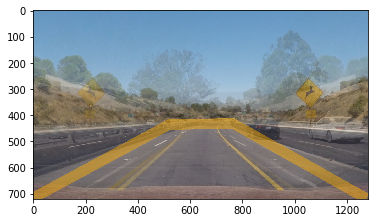

In [4]:
img = cv2.imread("writeup_images/superimpose_region_of_interest.jpg");
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

# Create Pipeline

## Methods for Thesholding by Gradients, Magnitude, Direction, Color and a Polygonal Mask (ROI)

Starter code was retrieved from the course modules and my prior Lane-Lines-P1 project

In [5]:
##### starter code from CarND module: "30. Color and Gradient module"

# Define a function that applies Sobel x and y, then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)): ## FROM "22. Magnitude of Gradient" course module
    
    # Apply the following steps to img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)                   # 1) Convert to grayscale
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # 2) Take the gradient in x and y separately
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(sobelx*sobelx + sobely*sobely)                   # 3) Calculate the magnitude
    scaled_mag = np.uint8(255*mag/np.max(mag))                     # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    binary_output =  np.zeros_like(scaled_mag)                     # 5) Create a binary mask where mag thresholds are met
    binary_output[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1
    return binary_output                                           # 6) Return this mask as your binary_output image

# Define a function that applies Sobel x and y, then computes the direction of the gradient
# and applies a threshold.
def dir_thresh(img, sobel_kernel=3, thresh=(0, np.pi/2)): ## from "23. Direction of the gradient" course module
    
    # Apply the following steps to img
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)                   # 1) Convert to grayscale
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # 2) Take the gradient in x and y separately
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)                               # 3) Take the absolute value of the x and y gradients
    abs_sobely = np.absolute(sobely)
    direction = np.arctan2(abs_sobely, abs_sobelx)                 # 4) Calculate the direction of the gradient
    binary_output = np.zeros_like(direction)                       # 5) Create a binary mask where direction thresholds are met
    binary_output[(direction >= thresh[0]) & (direction <= thresh[1])] = 1
    return binary_output                                            # 6) Return this mask as your binary_output image

def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255): ## from "21. Applying Sobel" course module
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)                     # Convert to grayscale
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))   # Apply x|y gradient with  OPenCV Sobel() function
    if orient == 'y':                                                # and take the absolute value
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))         # Rescale back to 8 bit integer
    binary_output = np.zeros_like(scaled_sobel)                      # Create a copy and apply the threshold
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    return binary_output                                             # Return the result

def hls_thresh(img, h_threshold=(0,180), l_threshold=(0,255), s_threshold=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    H = hls[:,:,0] ##  range is 0..180
    L = hls[:,:,1] ##  range is 0..255
    S = hls[:,:,2] ##  range is 0..255
            
    binary_output = np.zeros_like(H)
    binary_output[
        (H >= h_threshold[0]) & (H <= h_threshold[1]) &
        (S >= s_threshold[0]) & (S <= s_threshold[1]) &
        (L >= l_threshold[0]) & (L <= l_threshold[1])
    ] = 1
    return binary_output

def region_of_interest(img):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """    
    vertices, clip = carnd_camera()
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        matched_mask_color = (1.0,) * channel_count
    else:
        matched_mask_color = 1
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, matched_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = np.zeros_like(img)
    cv2.bitwise_and(src1=img, src2=mask, dst=masked_image)
    return masked_image

## Assemble the Pipeline

This step took some trial and error. In the end, I determined that using a yellow color mask, a white color mask and an ROI mask were sufficient in assembling a capable pipeline.

Even though I neglected to use gradient, direction and magnitude filters, the source still remains above and below so that visual verification of those methods is confirmed. It is envisioned that I may want to incorporate these later and this is a good way to maintain and recall the learning that I accomplished.

The following cell contains the final pipeline that was established. Validation images for each filter and the final combined filter follows in the next two cells.

Note that the original image is not undistorted (aka warped) in this step, that will follow in the next section.

In [6]:
"""
pipeline() processes an iput image, applying several filters and returning a binarized 
image where white pixels indicate evidence of lane lanes, and black pixels represent 
an absence of lane lines
"""
def pipeline(img, detailed=False):
    img = np.copy(img)
    
    # Sobel x,y
    gradx = abs_sobel_thresh(img, orient='x', thresh_min=20)
    grady = abs_sobel_thresh(img, orient='y', thresh_min=20)
    
    # in HLS, H 0..180, yellow = 20,30
    yellow_binary = hls_thresh(img, h_threshold=(20,35), l_threshold=(0,255), s_threshold=(0,255))
    white_binary = hls_thresh(img, h_threshold=(0,180), l_threshold=(200,255), s_threshold=(0,255))
    mag_binary = mag_thresh(img, mag_thresh=(50, 255))
    dir_binary = dir_thresh(img, thresh=(1/8 * np.pi, 3/8 * np.pi))
    
    combined = np.zeros_like(yellow_binary)  # from "24.Combining Thresholds" course module
    combined[(((yellow_binary == 1) | (white_binary == 1)))] = 1
    combined = region_of_interest(combined)
    
    if detailed:
        return gradx, grady, yellow_binary, white_binary, mag_binary, dir_binary, combined
    else:
        return combined

# Test the Pipeline

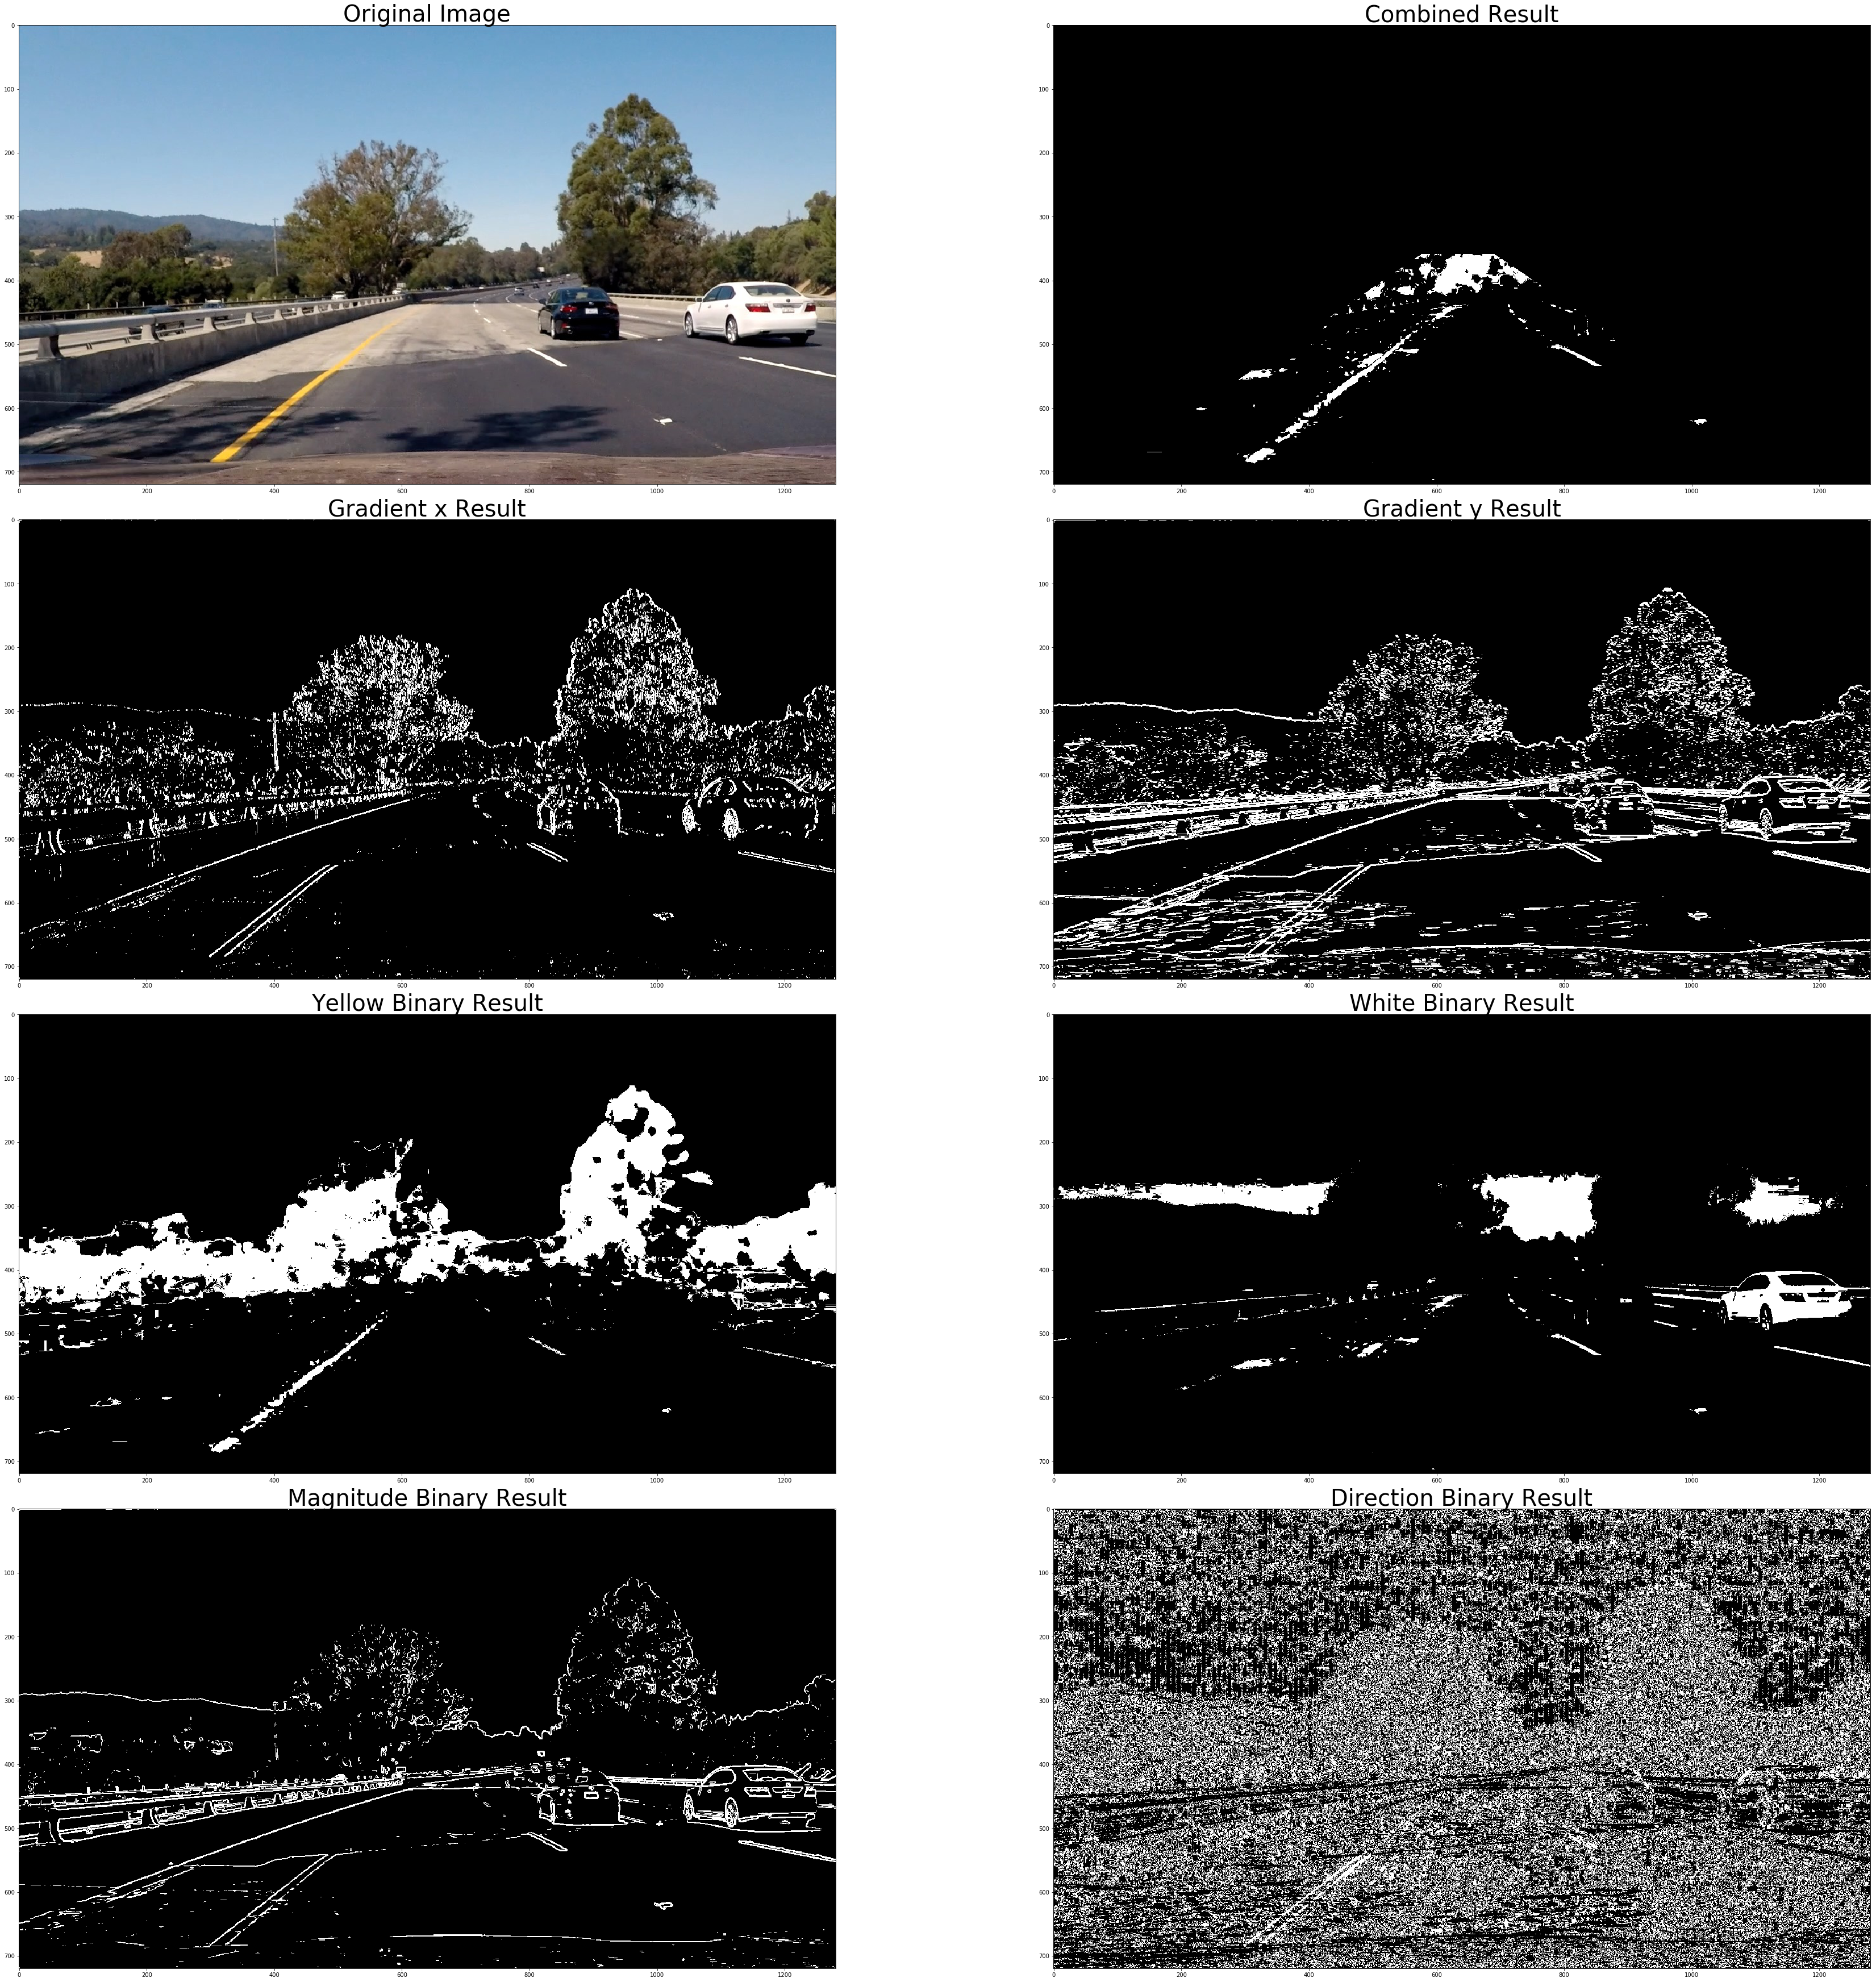

In [7]:
image = mpimg.imread('test_images/test4.jpg')
gradx, grady, yellow_binary, white_binary, mag_binary, dir_binary, binary_result = pipeline(image, detailed=True)

f, axes = plt.subplots(4, 2, figsize=(50, 25)) # Plot the result
f.tight_layout()

axes[0,0].imshow(image)
axes[0,0].set_title('Original Image', fontsize=40)
axes[0,1].imshow(binary_result, cmap='gray')
axes[0,1].set_title('Combined Result', fontsize=40)

axes[1,0].imshow(gradx, cmap='gray')
axes[1,0].set_title('Gradient x Result', fontsize=40)
axes[1,1].imshow(grady, cmap='gray')
axes[1,1].set_title('Gradient y Result', fontsize=40)

axes[2,0].imshow(yellow_binary, cmap='gray')
axes[2,0].set_title('Yellow Binary Result', fontsize=40)
axes[2,1].imshow(white_binary, cmap='gray')
axes[2,1].set_title('White Binary Result', fontsize=40)

axes[3,0].imshow(mag_binary, cmap='gray')
axes[3,0].set_title('Magnitude Binary Result', fontsize=40)
axes[3,1].imshow(dir_binary, cmap='gray')
axes[3,1].set_title('Direction Binary Result', fontsize=40)

plt.subplots_adjust(left=0., right=1, top=1.9, bottom=0.)

# Perspective Transform

This section provides the methods use to undistort a camera image image as well as transforming image data from a front-facing camera view to an overhead or 'bird's eye' view. In both cases, I've used a method that accepts an input image and returns a modified view (also an image). The warp() method also returns transformation matrices, useful for further downstream warp or unwarp (backPlot()) operations.

In [8]:
"""
transform camera distorted view to undistorted view. Use well described shape (rectangluar 
lane section) and map it to a truly rectangular section of a target image, ready for further 
analysis.
"""
def warp(img):
    shape = (img.shape[1], img.shape[0])
    if debug:
        print("transforming forward camera image to topdown view, img shape = {}".format(shape))
    from_box = np.float32([[310,681],[567,485],[788,485],[1022,681]])
    offset=np.float32([200,0])
    src = np.float32([from_box[0],from_box[1],from_box[2],from_box[3]])
    dst = np.float32([np.array([0,shape[1]]) + np.array(offset),
                      np.array([0,0.5*shape[1]]) + np.array(offset),
                      np.array([shape[0],0.5*img.shape[0]]) - np.array(offset),
                      np.array([shape[0],img.shape[0]]) - np.array(offset)
        ])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    warped = cv2.warpPerspective(img, M, shape, flags=cv2.INTER_LINEAR)  
    return warped, M, Minv
"""
transform forward-facing vehicle camera image to a topdown view, using mtx and dist as previously
calculated during camera calibration step (above)
"""
def forwardCameraToBirdsEye(img):
    global M, Minv
    binary_result = pipeline(img, detailed=False)
    binary_warped,M,Minv = warp(cv2.undistort(binary_result, mtx, dist, None, mtx))
    return binary_warped

# Validate Perspective Transform Methods

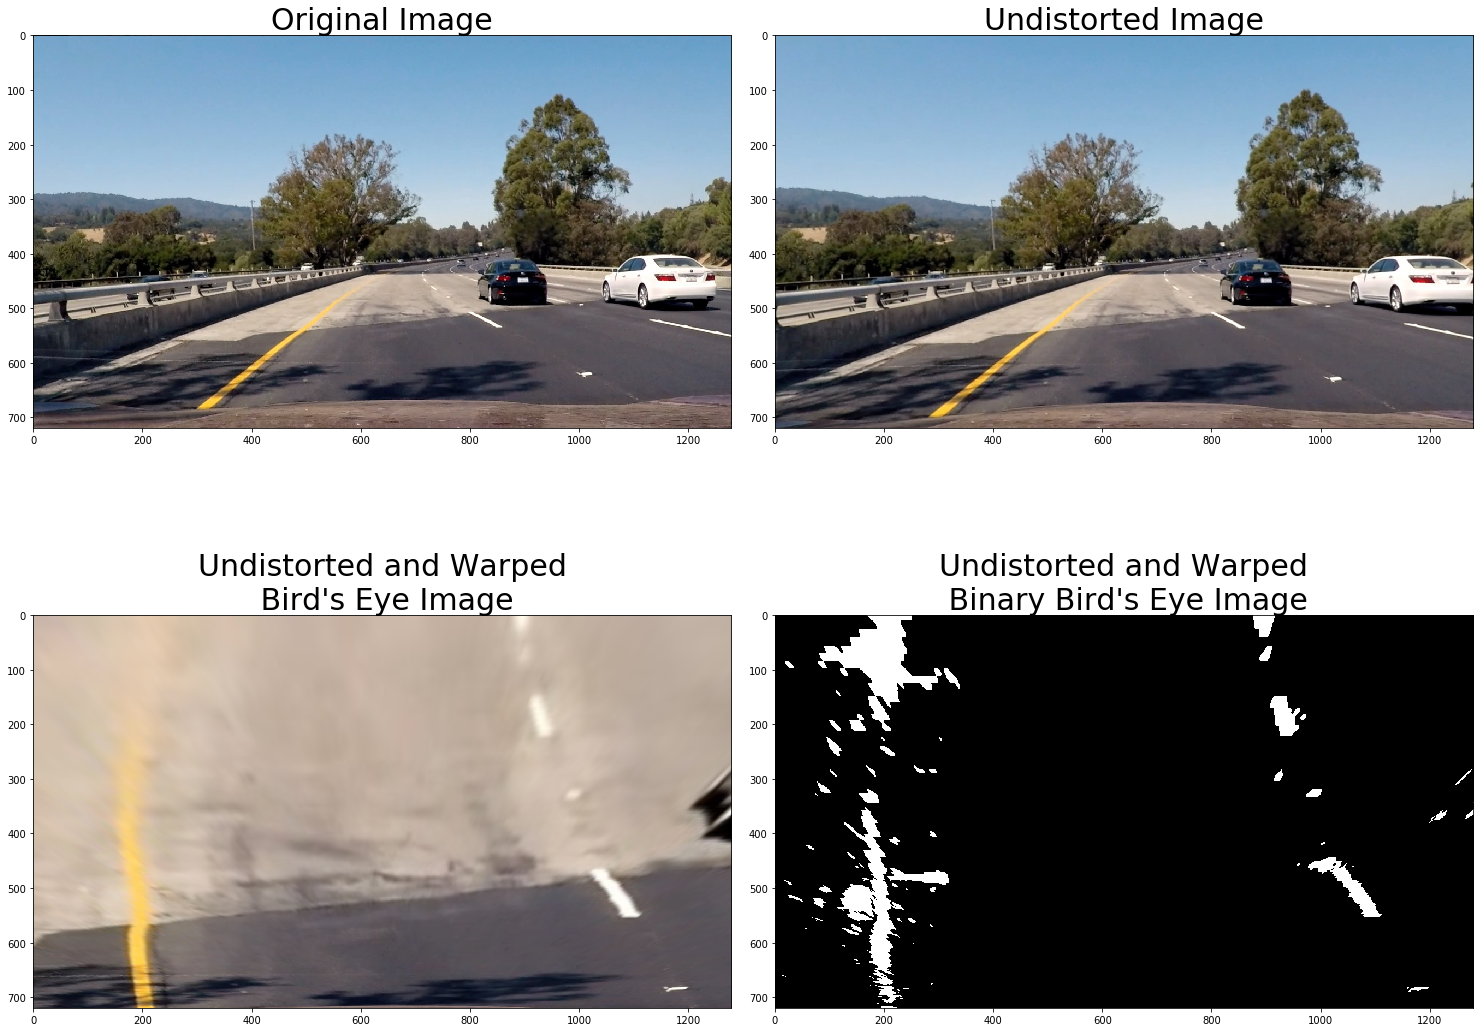

In [9]:
image = mpimg.imread('test_images/test4.jpg')

img_undistort = cv2.undistort(image, mtx, dist, None, mtx)
img_warped, _, _ = warp(img_undistort)
binary_warped = forwardCameraToBirdsEye(image)
                        
f, axes = plt.subplots(2, 2, figsize=(20, 9))
f.tight_layout()
axes[0,0].imshow(image)
axes[0,0].set_title('Original Image', fontsize=30)
axes[0,1].imshow(img_undistort)
axes[0,1].set_title('Undistorted Image', fontsize=30)
axes[1,0].imshow(img_warped)
axes[1,0].set_title("Undistorted and Warped\n Bird's Eye Image", fontsize=30)
axes[1,1].imshow(binary_warped, cmap='gray')
axes[1,1].set_title("Undistorted and Warped\n Binary Bird's Eye Image", fontsize=30)
plt.subplots_adjust(left=0., right=1, top=1.7, bottom=0.)

# Visual Peaks, Should be Bimodal

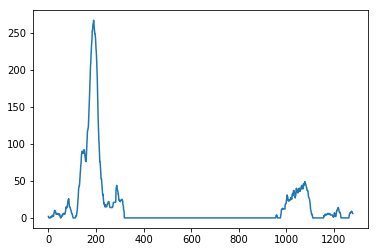

In [10]:
# visualize the peaks from the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

# Detect Lane Lines

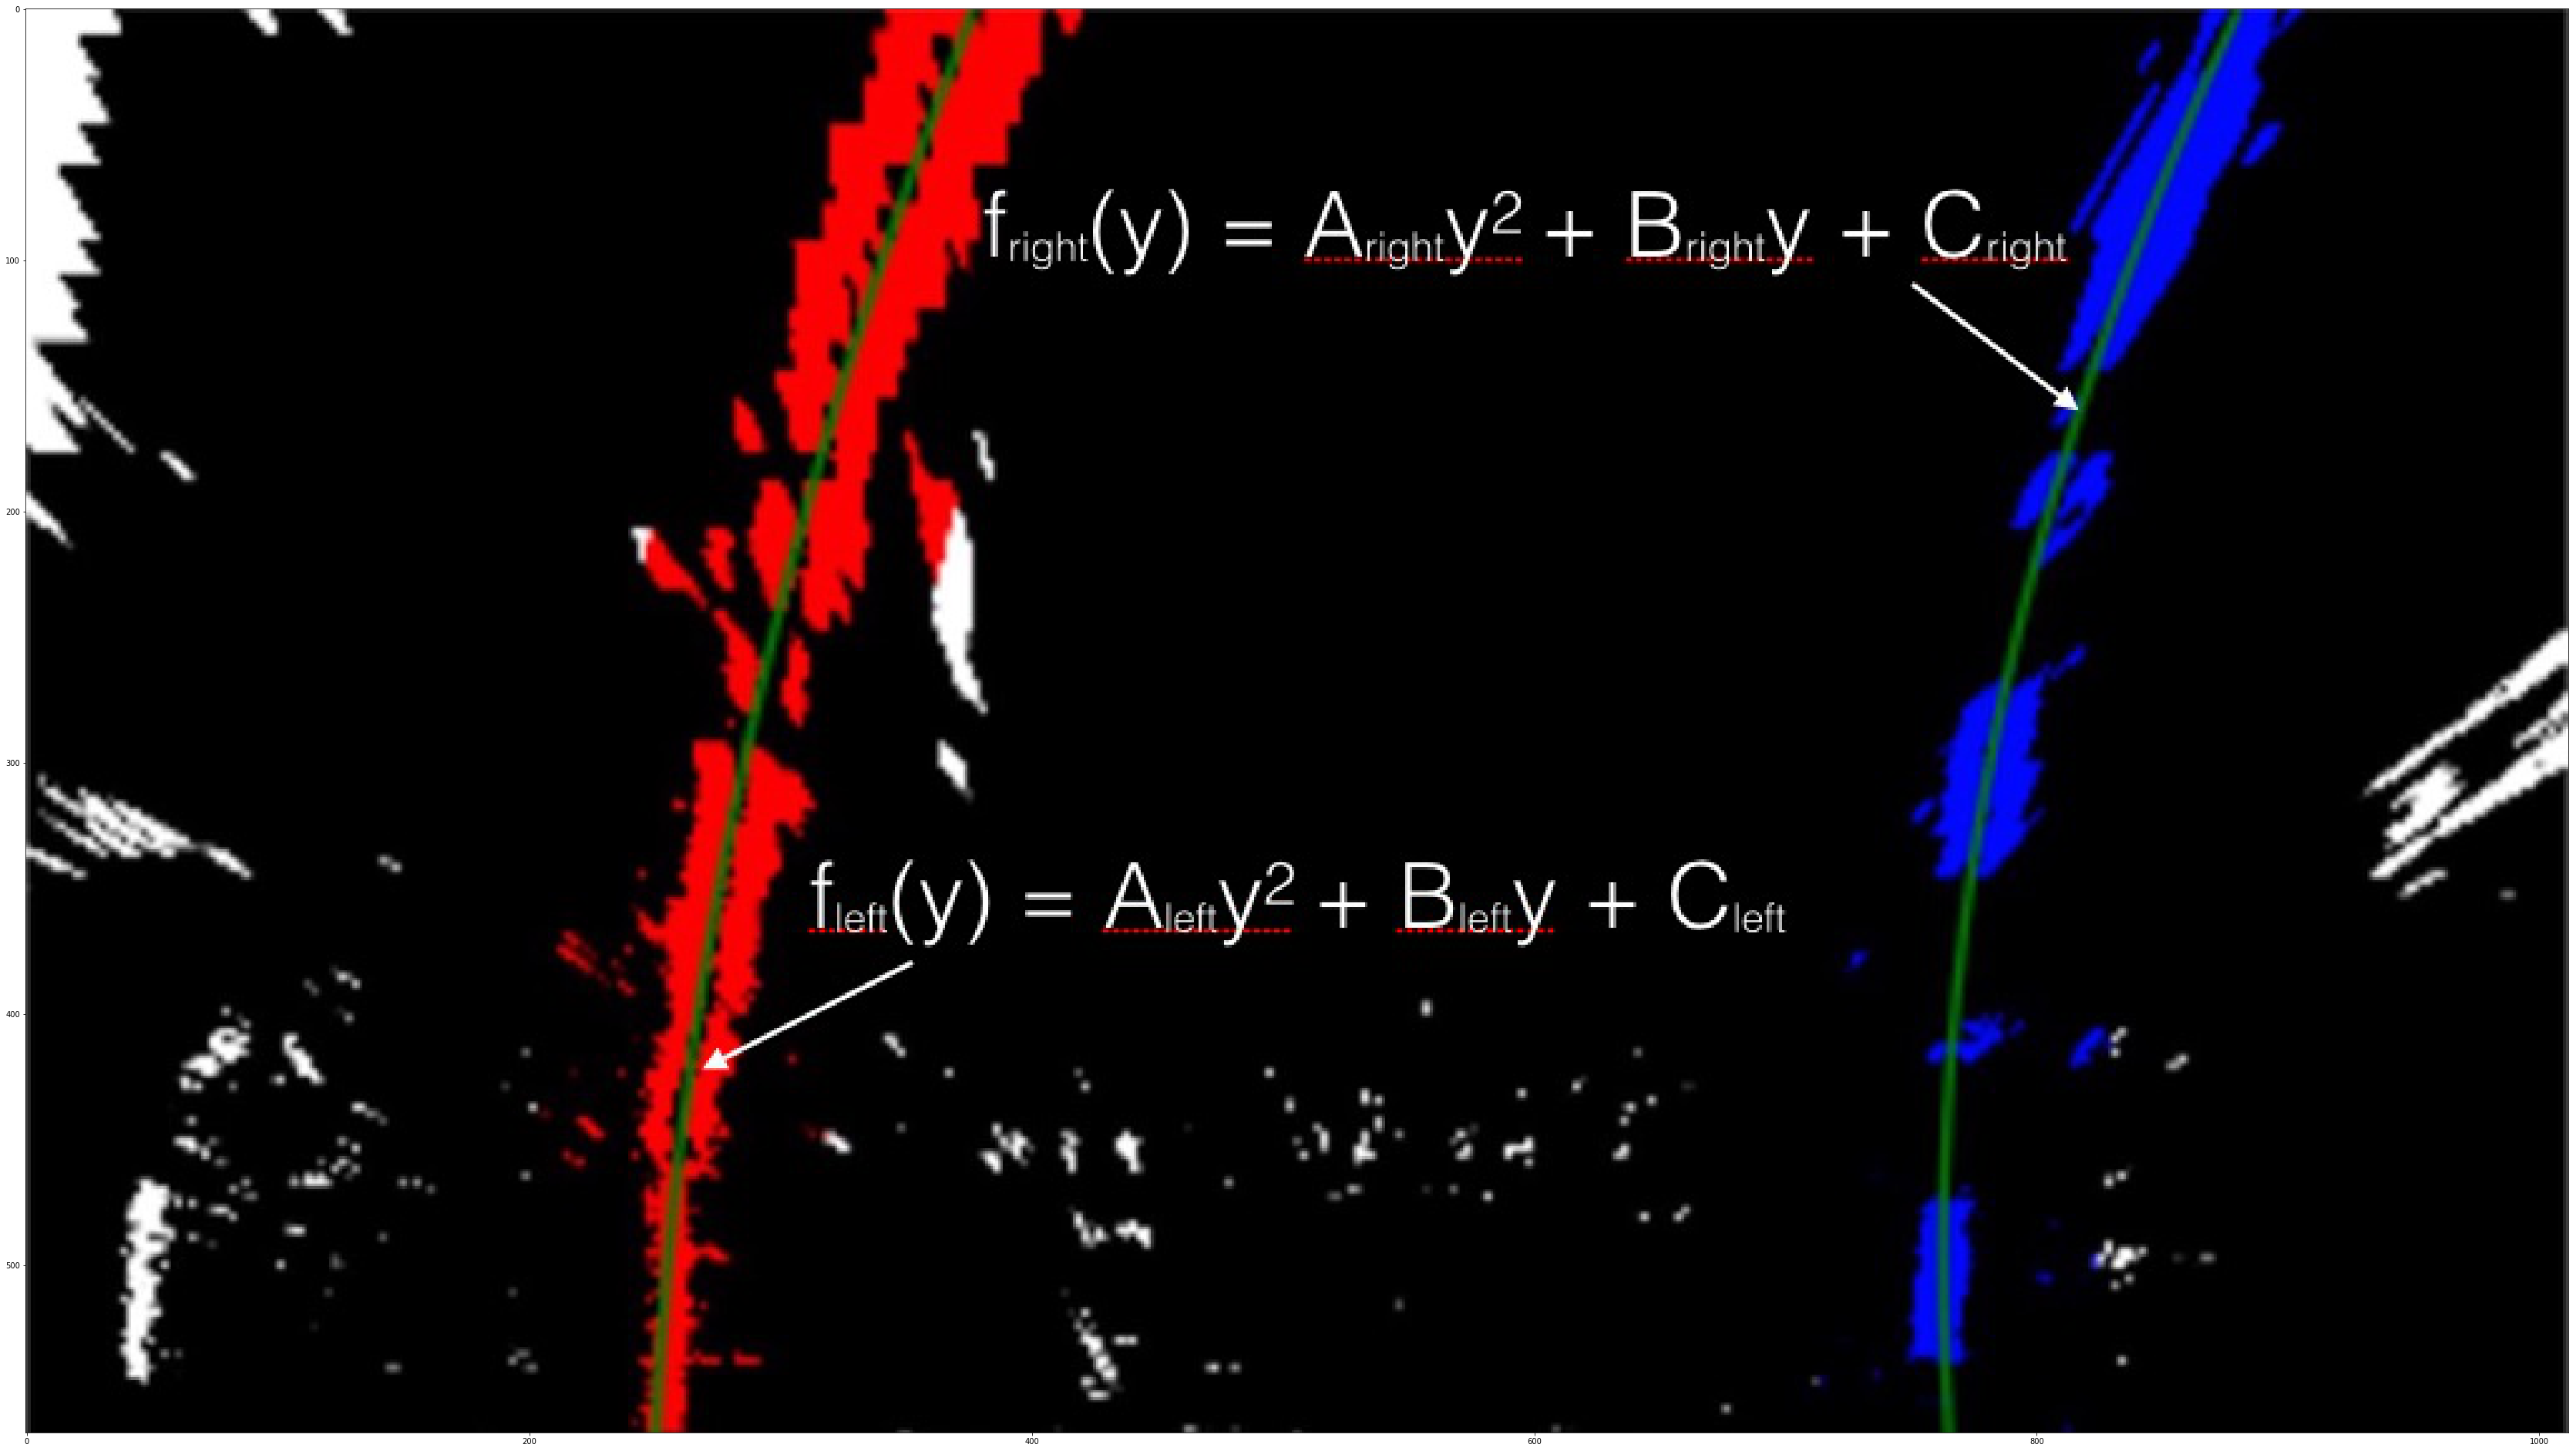

In [11]:
img = cv2.imread("writeup_images/color_fit_lines.jpg");
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
fig, ax = plt.subplots(figsize=(60, 34))
ax.imshow(img)

To detect lane lines, I begin with the approach and starter code found in the course modules. 

With the data illustrated in the histogram above, I search for clusters of points (within a specified margin) of the two peaks, as illustrated. Next, the binary bird's eye image is stratofied into a number of stacked layers. For each layer, a left and right rectangular region is identified (see the diagram four cells below). Once each rectangular region is identified, the average of contained x coordinates is calculated and the next higher row is analyzed. A sliding window approach is applied to that new region to adjust its average according to the data found within that window. This process is continued until af the layers have been analyze, from bottom to top. At this point, a second-order, least squares polynomial is fit to the data points for each lane line (as illustrated in the image above, which was taken from the course materials).

An abbreviated process is followed on subsequent invocations for new video frames, since I don't need to start all the way back at the histogram with sliding windows. Rather than conducting a blind search again, I search in a margin around the previous line position to adjust the lane anchor points.

The following three code cells build and exercise the lane line functionality:

The next code cell contains the detectLanes() method, which performs sliding window and subsequent searches. Additonally, detectLanes() calculates the distance between the center line of the vehicle and lane's centerline, by determining the difference between the image center and midpoint between the histogram's two most prominent peaks. The pixel value is converted to real world coordinates.

The following code cell contains the definition of the LaneLine() class, which is used to store and manipulate lane data. LaneLine also determines lane line curvature by using the starter code from the course module (35. Measuring Curvature), and further described here: https://www.intmath.com/applications-differentiation/8-radius-curvature.php. LaneLine incorprates a low pass filter, to reduce transient effects as lane line radii are measured from frame to frame. When curvatures that are less than US goverment specs allow for 130 km/h (832m), the heads-up-display text will toggle from white to red.

Finally, in the third cell below, you will find code to exercise and validate the lane detection methods. 

## Methods and Classes

In [12]:
def detectLanes(binary_warped, left_lane_line, right_lane_line):
    
    global first_frame
    
    margin = 100 ## width of the windows +/- margin
    minpix = 50  ## minimum number of pixels found to recenter window
    
    if first_frame:     
        # Take a histogram of the bottom half of the image
        ## from "33. Finding the lines" in CardND course module
        bottom_rows = binary_warped.shape[0]//2
        histogram = np.sum(binary_warped[bottom_rows:,:], axis=0)

        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        nwindows = 9 ## number of sliding windows
        window_height = np.int(binary_warped.shape[0]/nwindows)

        # Create an output image to draw on and visualize the result
        out_img = (np.dstack((binary_warped, binary_warped, binary_warped)) * 255).astype(np.uint8)

        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            if debug:
                print("{} {} {} {} {} {}".format(win_y_low, win_y_high, 
                    win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
            (0,255,0), 4) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
            (0,255,0), 4) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
            (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)

        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        first_frame = False
    else:
        # We ennter with a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        ## also from "33. Finding the lines" in CardND course module
        
        # Create an output image to draw on and visualize the result
        out_img = (np.dstack((binary_warped, binary_warped, binary_warped)) * 255).astype(np.uint8)

        left_fit = left_lane_line.current_fit;
        right_fit = right_lane_line.current_fit;
        
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
        left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
        left_fit[1]*nonzeroy + left_fit[2] + margin))) 

        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
        right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
        right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        
        leftx = nonzerox[left_lane_inds]       # Again, extract left and right line pixel positions
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        left_fit = np.polyfit(lefty, leftx, 2) # Fit a second order polynomial to each
        right_fit = np.polyfit(righty, rightx, 2)
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] ) # Generate x and y values for plotting
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    # persist values to R/L LaneLine objects
    left_lane_line.update(left_fitx, ploty, left_fit)
    right_lane_line.update(right_fitx, ploty, right_fit)
    
    lane_width_px = np.mean(right_fitx) - np.mean(left_fitx)
    lane_center_px = np.mean(left_fitx) + lane_width_px/2
    vehicle_dist_from_center_px = 640 - lane_center_px;
    vehicle_dist_from_center_m = vehicle_dist_from_center_px * xm_per_pix;

    return  out_img, vehicle_dist_from_center_m

In [13]:
# class to track status
class LaneLine():
        
    def __init__(self):
        
        #radius of curvature of the line in some units
        self.radius_of_curvature = 0 
        #polynomial coefficients for the most recent fit
        self.current_fit = np.polyfit([0 ,0], [1,1], 1)
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        # last y values corresponding to the xfitted  set
        self.y = []
        # influence of prior values of radius, used in low pass filter
        self.α = 0.95; 
        
    def update(self, fitx, y, fit):
        self.xfitted = fitx;
        self.y = y;
        self.current_fit = fit;
        self.calculateCurvature(fit, fitx, y)

    def calculateCurvature(self, fit, fit_pts, y): ## starter code from "35. Measuring Curvature" course module
        # calculate radius of curvature at bottom of the screen (or, essentially, at the from bumper)
        y_max = np.max(y)
        curverad = ((1 + (2*fit[0]*y_max + fit[1])**2)**1.5) / np.absolute(2*fit[0])
        # Fit new polynomials to x,y in world space
        fit_world = np.polyfit(y*ym_per_pix, fit_pts*xm_per_pix, 2)
        # Calculate the new radii of curvature, in m
        curverad_world = ((1 + (2*fit_world[0]*y_max*ym_per_pix + fit_world[1])**2)**1.5) / np.absolute(2*fit_world[0])
        if debug:
            print("curvature = {} m",format(curverad_world))
        self.lowpass(curverad)
        return curverad_world

    # Establish a low pass filter for left and right curvatures
    def lowpass(self, latest):          ## de-emphasize transient forces
        self.radius_of_curvature = self.radius_of_curvature * (1-self.α) + latest * self.α
        return self.radius_of_curvature ## α indicates the influence level of past observations
        
        

## Detect in Single Frame, Confirm by Visualization 

(720, 0)

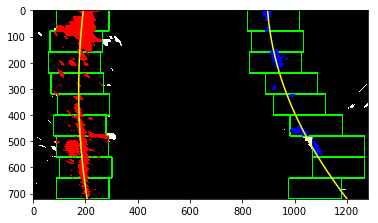

In [14]:
# also from "33. Finding the lines" in CardND course module
left_lane_line = LaneLine()
right_lane_line = LaneLine()
out_img, distance = detectLanes(binary_warped, left_lane_line, right_lane_line)

plt.imshow(out_img)
plt.plot(left_lane_line.xfitted, left_lane_line.y, color='yellow')
plt.plot(right_lane_line.xfitted, right_lane_line.y, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

# Validating the Entire Pipeline

The methods in the following four code cells create a complete image processing pipeline that 
can be applied to each frame of vehicle camera video. 

backPlot() takes the original camera image and annotates it with detected lane infornmation. This information includes the lane boundaries, the curvature of the left and right lane markings, and the distance of the car's center from the lane center. Low curvature values are signalled in red.

processImage() encapsulates all steps required to manipulate a raw video frame and return an undistorted, annotated frame, ready for inclusion into the video. The two other code cells exercise the backPlot() and proces_image() methods for an individual image for verification purposes.

In [15]:
# method to siperimpose fitted lines to original image
def backPlot(image, Minv, mtx, dist, binary_warped, left, right):
    # starter code from "36. Tips and Tricks for the Project" course module
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left.xfitted, left.y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right.xfitted, right.y])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    return result

## Validate Backplotter 

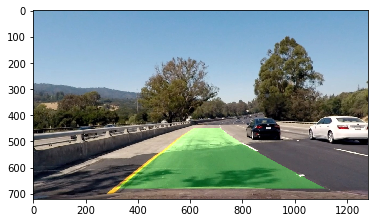

In [16]:
result = backPlot(image, Minv, mtx, dist, binary_warped, left_lane_line, right_lane_line)
plt.imshow(result)

In [17]:
def process_image(image):
    # NOTE: return processed image for video processing, below 
    # mtx and dist must already be set globally

    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    lineType = 2
    
    binary_warped = forwardCameraToBirdsEye(image)
    out_img, distance = detectLanes(binary_warped, left_lane_line, right_lane_line)
    result = backPlot(image, Minv, mtx, dist, binary_warped, left_lane_line, right_lane_line)
    
    side = 'left' if distance >= 0 else 'right'
    t1 = "Lane Curvature Left: {0:5.0f}m Right: {1:5.0f}m". \
        format(round(left_lane_line.radius_of_curvature, 0),
               round(right_lane_line.radius_of_curvature, 0))
    t2 = "Distance {:.1f} to the {} of center".format(round(abs(distance),1), side)
    
    # minimum radius from 
    # http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC
    if  min(left_lane_line.radius_of_curvature, right_lane_line.radius_of_curvature) < 832:
        fontColor=(255,0,0)
    else:
        fontColor = (255,255,255)
        
    cv2.putText(result, t1, (10,50), font, fontScale, fontColor, lineType)
    cv2.putText(result, t2, (10,100), font, fontScale, fontColor, lineType)
    
    return result

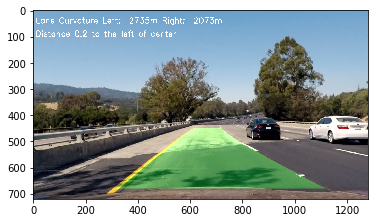

In [18]:
# unit test the processor
first_frame = True;
testImage = mpimg.imread('test_images/test4.jpg')
result = process_image(testImage)
plt.imshow(result)

# Finally, the Entire Video Processor

In [19]:
output = 'output_videos/advanced_lane_lines.mp4'
v_clip = VideoFileClip("project_video.mp4")

first_frame = True;
left_lane_line = LaneLine()
right_lane_line = LaneLine()

clip = v_clip.fl_image(process_image)
%time clip.write_videofile(output, audio=False)

HTML("""<video width="640" height="360" controls><source src="{0}"></video>""".format(output))

[MoviePy] >>>> Building video output_videos/advanced_lane_lines.mp4
[MoviePy] Writing video output_videos/advanced_lane_lines.mp4


100%|█████████▉| 1260/1261 [04:42<00:00,  4.50it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/advanced_lane_lines.mp4 

CPU times: user 5min 13s, sys: 1min 17s, total: 6min 31s
Wall time: 4min 43s


# Discussion

## Problems
The main problems I ran into building this project were:
* time allocation required to complete it
* working with python and associated libraries, I'm still ramping up on these
* understanding the inconsistencies between python libraries (RGB/BGR, shape dimensions, etc.)

## Limitations

While this pipeline works well for the video provided, I anticipate there will be severe issues with generaliztion. More specifically, I suspect the pipeline will underperform when:
* weather changes 
* streets have differnt characteristics: residential, industrial, urban, etc.
* field of view becomes obstructed with debris on camera or roadway 
* lighting conditions change: night, cloudy, whiteout, dawn, twilight, etc.

In addition to the concerns listed above, performance will be a serious consideration. I ran my simulation on a very recent high-end Mac, it took about one minute to render each 10 seconds of video.


## Improving
Several strategies can be employed to overcome the shortcomings listed above. For example, we could:
* perform more sanity checking as each frame arrives, adding mitigation based on the defect found
* develop and test with more data, in more scenarios
* combine the results with other approaches, such as machine learning
* get more accurate offset info with better determination of actual lane width geometry




